# **Inkrement 2 - Betriebszustandsmonitoring einer Drohnenfernsteuerung via Machinelearning**

# Zielsetzung

In diesem Inkrement wird eine Drohnenfernsteuerung entwickelt. Die Fernsteuerung soll mithilfe eines k-NN-Klassifikators, die drei Zustände Ruhe, Fernsteuerung und Transport korrekt Klassifizieren können. Als Grundlage der Klassifizierung werden Sensordaten eines MPU6050 verwendet. Es soll zudem untersucht werden, welche Qualität der Klassifizierung sich mit unverarbeiteten und mit weiterverarbeitetet Sensordaten erreichen lässt. Als Qualitätsmaß wird die Accuracy auf Trainings und Validierungsdaten herangezogen.

# Theorie

Der k-NN-Klassifikator (k-Nächste-Nachbarn) ist ein leicht zu implementierender Algorithmus im Bereich des maschinellen Lernens. Er geht davon aus, dass ähnliche Datenpunkte im Raum nahe beieinander liegen. Bei der Klassifikation eines neuen Datenpunktes werden die k nächsten Nachbarn herangezogen, und die Klasse wird durch Mehrheitsentscheidung festgelegt. Die Wahl des k-Werts beeinflusst die Algorithmusleistung, wobei ein zu niedriger Wert zu Überanpassung und ein zu hoher Wert zu Vernachlässigung lokaler Muster führen kann. Der k-NN-Klassifikator eignet sich besonders für nicht-lineare Datenstrukturen, da er vereinzelte, zusammenhängende Cluster präzise klassifizieren kann.

Für die Maximierung der korrekten Klassifizierungen mittels eines k-NN-Klassifikators ist die Auswahl geeigneter Messgrößen, auch Features genannt, aus den verfügbaren entscheidend. Dabei folgt oft der Grundsatz, dass mehr Features nicht zwangsläufig zu einem verbesserten Klassifizierungsergebnis führen, im Gegensatz zu sorgfältig ausgewählten einzelnen Features.

Die Bewertung der Leistung des trainierten Klassifikators erfolgt, wie üblich, durch die Genauigkeit (Accuracy). Darüber hinaus wird eine Konfusionsmatrix (Confusion Matrix) erstellt, um eine detailliertere Analyse der Klassifizierung bei Multiclass-Problemen zu ermöglichen.

# Hardwareaufbau

Die verwendete Hardware besteht aus einem Breadbord, einem ESP32 einem MPU6050 und einem Taster. Der Beschleunigungssensor MPU6050 ist über I2C mit dem ESP32 verbunden. Er liefert auf Befehl die Messgrößen Beschleunigung in X-,Y-, Z-Richtung und die Drehrate in X-, Y-, Z-Richtung und die Winkelbeschleunigung in X- und Y-Richtung. Als vorverarbeitete Messgrößen liefert er zudem auch den Winkel in X-, Y- und Z-Richtung.

# Durchführung

**Training:**

Die Datenerfassung erfolgt gemäß folgendem Verfahren: Der ESP32 übermittelt die Sensordaten des MPU6050 an den verwendeten MQTT-Broker. Durch ein Node-Red-Netzwerk werden die Daten in eine CSV-Datei geschrieben. Nachfolgend wird die CSV-Datei in Python eingelesen, einer Vorverarbeitung unterzogen und anschließend für das Training des k-NN-Klassifikators verwendet.

**Live-Klassifizierung:**

Im zweiten Schritt erfolgt der direkte Live-Import der Daten in Python, woraufhin sie mittels des trainierten k-NN-Klassifikators klassifiziert werden.


## 1. Einlesen der Datei und überprüfen, ob die Datenreihen vollständig sind

Zuerst müssen die Rohdaten geeignet vorverarbeitet werden, bevor weitere Analyse- und Verarbeitungsschritte folgen können.

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix as scatmat
import os


# Absolute Pfad zur Datei extrahieren
#ziel_pfad = 'D:\measurements'
ziel_pfad = '../Daten/'

# CSV-Datei einlesen
data = pd.read_csv(os.path.join(ziel_pfad, 'mpu6050_lennard_run1.csv'), sep=',', decimal='.')
data2 = pd.read_csv(os.path.join(ziel_pfad, 'mpu6050_lennard_run2.csv'), sep=',', decimal='.')
data = pd.concat([data, data2], ignore_index=True)

# Die ersten Zeilen anzeigen
data.head()

# Informationen über den Datensatz anzeigen
data.info()

# Gibt es Auffälligkeiten bei der Verteilung der Werte?
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AccX         9120 non-null   float64
 1   AccY         9120 non-null   float64
 2   AccZ         9120 non-null   float64
 3   GyroX        9120 non-null   float64
 4   GyroY        9120 non-null   float64
 5   GyroZ        9120 non-null   float64
 6   AngleX       9120 non-null   float64
 7   AngleY       9120 non-null   float64
 8   AngleZ       9120 non-null   float64
 9   AccAngleX    9120 non-null   float64
 10  AccAngleY    9120 non-null   float64
 11  RuheState    9120 non-null   int64  
 12  FernstState  9120 non-null   int64  
 13  TranspState  9120 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 997.6 KB


AccX         AccY         AccZ        GyroX        GyroY  \
count  9120.000000  9120.000000  9120.000000  9120.000000  9120.000000   
mean     -0.124444     0.120000     0.897729    -0.187314    -0.457338   
std       0.501435     0.421644     0.337752    41.130489    38.532537   
min      -1.640134    -1.847535    -1.105839  -498.599823  -299.504578   
25%      -0.404477    -0.013063     0.761731    -5.065466    -6.470230   
50%      -0.119626     0.033687     0.993933     0.407817     0.235877   
75%       0.054507     0.327636     1.036605     6.341107     5.233182   
max       1.857852     1.776244     2.463436   470.987976   354.999237   

             GyroZ       AngleX       AngleY       AngleZ    AccAngleX  \
count  9120.000000  9120.000000  9120.000000  9120.000000  9120.000000   
mean     -2.290510     7.328550     7.227452  -644.019330     7.175341   
std      38.004965    35.513037    33.610919   474.705076    29.835002   
min    -270.363739  -178.105057   -89.975670 -2336.003662  -179.495193   
25%      -4.305595    -1.009308    -0.168664  -799.939331    -0.730754   
50%      -0.317954     1.777564     8.704584  -526.080566     1.358691   
75%       1.483573    15.253549    29.498145  -327.444359    18.005214   
max     264.063751   161.326920    89.965271    71.008202   178.724503   

         AccAngleY    RuheState  FernstState  TranspState  
count  9120.000000  9120.000000  9120.000000  9120.000000  
mean      3.379365     0.319079     0.351974     0.328947  
std      26.025703     0.466145     0.477612     0.469857  
min     -88.617310     0.000000     0.000000     0.000000  
25%      -3.144068     0.000000     0.000000     0.000000  
50%       6.803437     0.000000     0.000000     0.000000  
75%      21.259746     1.000000     1.000000     1.000000  
max      86.276085     1.000000     1.000000     1.000000

## 2. Visualisierung der Verteilung der numerischen Werte

In diesem Schritt ist zu untersuchen, ob sich bereits an der Verteilung der Sensorwerte eine Klassenzugehörigkeit ausmachen lässt. Potentiell geeignete Features sollten im besten Fall ein trimodales oder bimodales Historgramm aufweisen. Features mit einem unimodalen Historgramm eignen sich hingegen nicht oder zumindest nicht unverarbeitet als Erkennungsmerkmal der Klassenzugehörigkeit.

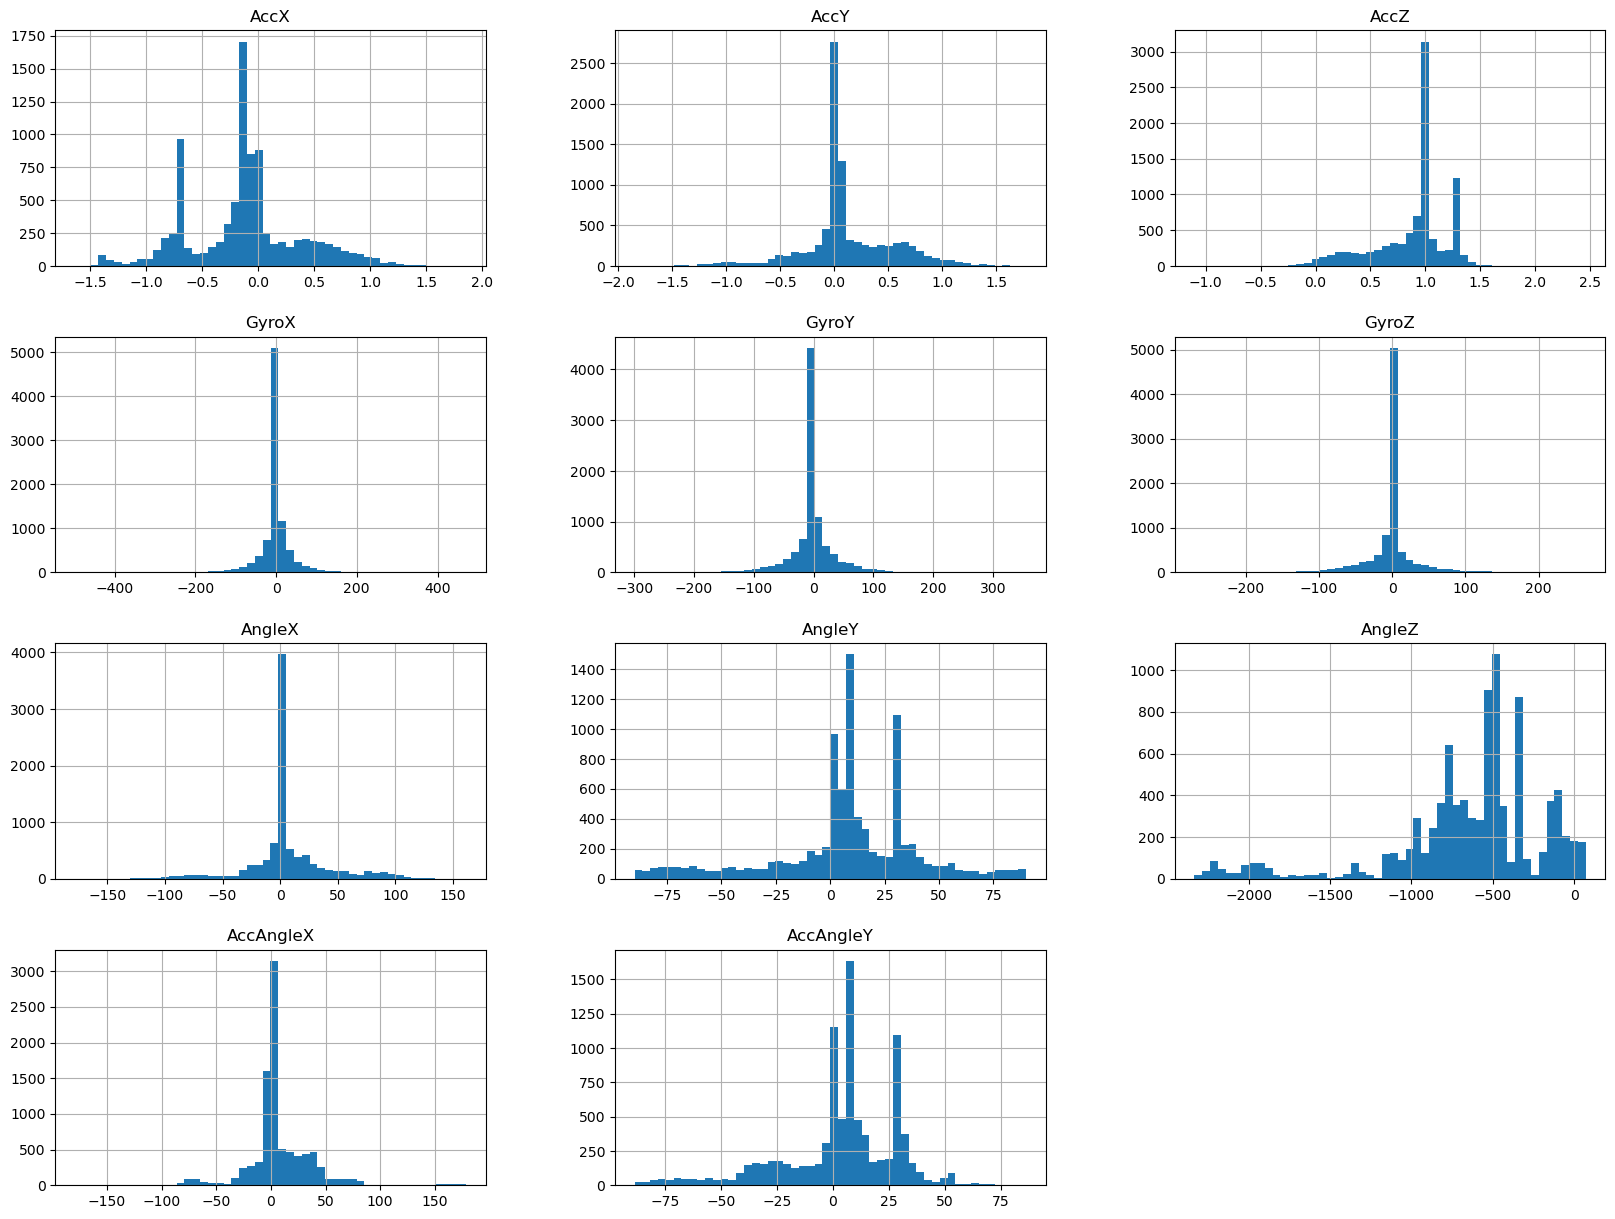

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

# Die ersten 12 Label-Spalten auswählen
feature_labels = data.columns[:11]

# Histogramm nur für die ausgewählten Label erstellen
data[feature_labels].hist(bins=50, figsize=(20, 15))
plt.show()

## 3. Überprüfen, ob es fehlerhafte Werte gibt (Bspw.: in Spalte 'AccX')

Zu einer geeigneten Vorverarbeitung gehört die Entfernung oder Korrektur von fehlerhaften Zeilen. Nur so kann der k-NN-Klassifikator später korrekt trainiert werden.

In [36]:
pd.set_option('display.max_rows', 300)
data['AccX'].value_counts()

AccX
-0.030027    27
-0.126951    25
-0.027830    25
-0.117917    25
-0.029783    24
             ..
 0.233157     1
 0.383059     1
 0.303713     1
 0.115481     1
 0.131451     1
Name: count, Length: 4662, dtype: int64

## 4. Fehlerhaften Wert korrigieren (Beispielhafte Anleitung zum Vorgehen)

In diesem Abschnitt ist veranschaulicht, wie fehlerhafte Werte oder falsche Datenformate korregiert werden.

In [37]:
# Auswahl und Korrektur eines fehlerhaften Wertes
# data.loc[data['AccX'] == '-14420-11-2011 04:50:23.713', 'AccX'] = -144

# String in numerischen Wert überführen:
# Spalte 'AccX' in numerischen Typ umwandeln
# data['AccX'] = pd.to_numeric(data['AccX'])

# Informationen über den Datensatz erneut anzeigen
# data.info()

## 5. Anwendung einer Skalierungsfunktion zur Normierung der Werte

Da der k-NN-Klassifikator Klassifizierungen anhand von Abständen von Trainingsdatenpunkten im Merkmalsraum vornimmt müssen die Sensorwerte skaliert werden. Gängige Skalierungsfunktionen sind der MinMaxScaler, der die Daten anhand des kleinsten und größten vorkommenden Wertes Skaliert und der Standard Scaler, der die Daten in eine Normalverteilung mit Standardabweichung 1 überführt. Experimentell konnte jedoch nachgewiesen werden, dass sich für den Anwendungsfall der Drohnenfernsteuerung, der Robustskaler, eine Mischung aus dem MinMaxScaler und dem Standardscaler zur höchsten bestimmten Accuracy führt. Im weiteren Verlauf wurde daher der Robust Scaler verwendet. Der Vollständigkeit halber wurde trotzdessen der MinMaxScaler und der Standardscaler als Beispielcode ergänzt.

### MinMaxScaler und Standard Scaler

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Erstellen einer Instanz der MinMaxScaler-Klasse und der StandardScaler-Klasse
#scaler = MinMaxScaler()
#scaler = StandardScaler()

# Skalieren der Daten (entsprechend der einkommentierten Zeile der Scaler-Instanz)
#data_scaled = scaler.fit_transform(data)

### Robust Scaler 

In [39]:
# Dies ist eine Alternative zum MinMaxScaler, der robust gegenüber auffällig hohe und tiefe Werte ist
from sklearn.preprocessing import RobustScaler

# Erstellen einer Instanz der RobustScaler-Klasse
scaler = RobustScaler()

# Anwenden des Skalierers
data_scaled = scaler.fit_transform(data)

## 6. Berechnen der Standardabweichung zu jedem Feature (Datenweiterverarbeitung)

In diesem Schritt wird zu jedem Feature die Standardabweichung berechnet. Mit diesen Werten soll in den folgenden Schritten das Training des k-NN-Klassifikators durchgeführt werden.

In [40]:
# Blockgröße für Berechnungen
chunk_size = 30

data_scaled_pp_df = pd.DataFrame(data_scaled, columns=data.columns)

# Anzahl der Blöcke berechnen
num_chunks = len(data_scaled_pp_df) // chunk_size

# Verarbeitung in Blöcken durchführen
processed_data_list = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size

    chunk = data_scaled_pp_df.iloc[start_index:end_index, :]

    # Standardabweichung für ausgewählte Spalten berechnen
    selected_columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'AccAngleX', 'AccAngleY']
    std_deviation = chunk[selected_columns].std().to_frame().transpose()

    # Mittelwert für andere Spalten berechnen
    other_columns = ['RuheState', 'FernstState', 'TranspState']
    mean_values = chunk[other_columns].mean().to_frame().transpose()

    # Neue Daten erstellen
    processed_data = pd.concat([std_deviation, mean_values], axis=1)
    
    processed_data_list.append(processed_data)

# Alle berechneten Blöcke zusammenführen
result_data = pd.concat(processed_data_list, ignore_index=True)

result_data

AccX      AccY      AccZ     GyroX     GyroY      GyroZ    AngleX  \
0    0.590076  0.482139  0.593857  2.898860  6.817292  11.219566  0.653033   
1    0.643513  0.634474  0.905397  2.427609  3.746630   7.006120  0.581494   
2    0.532066  0.497241  0.853755  1.740741  3.235376   6.350787  0.476021   
3    0.418201  0.540842  0.721449  1.708017  2.398082   5.156932  0.376013   
4    0.482453  0.553340  0.992473  2.568790  4.256631   7.890122  1.093375   
..        ...       ...       ...       ...       ...        ...       ...   
299  0.013408  0.010436  0.029364  0.011180  0.012857   0.018874  0.004170   
300  0.007559  0.010818  0.014829  0.010129  0.016779   0.017552  0.001727   
301  0.005313  0.008678  0.015759  0.013497  0.024577   0.018408  0.002361   
302  0.005523  0.010813  0.019657  0.009274  0.015672   0.013317  0.002230   
303  0.007619  0.014909  0.044356  0.022322  0.056959   0.022332  0.002952   

       AngleY    AngleZ  AccAngleX  AccAngleY  RuheState  FernstState  \
0    1.391882  0.050580   0.484182   0.595847        0.0          0.0   
1    0.764272  0.073811   0.525120   0.540015        0.0          0.0   
2    0.535679  0.029740   0.430536   0.461343        0.0          0.0   
3    0.288011  0.051433   0.424461   0.341526        0.0          0.0   
4    1.215285  0.097986   0.461859   0.390394        0.0          0.0   
..        ...       ...        ...        ...        ...          ...   
299  0.000846  0.000426   0.010718   0.012538        1.0          0.0   
300  0.000560  0.000424   0.011149   0.008335        1.0          0.0   
301  0.001087  0.000421   0.008953   0.005900        1.0          0.0   
302  0.000549  0.000444   0.011114   0.006038        1.0          0.0   
303  0.001430  0.000419   0.015430   0.007883        1.0          0.0   

     TranspState  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0  
..           ...  
299          0.0  
300          0.0  
301          0.0  
302          0.0  
303          0.0  

[304 rows x 14 columns]

## 7. Aufteilung des Datensatzes in Trainings- und Validierungsdaten

Bei der Entwicklung einer Machinelearning basierten Klassifizierung ist das Aufsplitten der Messdaten in Trainings und Valisierungsdaten gängig, um die Generalisierbarkeit des Modells auf unbekannte Daten zu überprüfen. Der Datensatz wird in 80% Trainingsdaten und 20% Validierungsdaten aufgeteilt.

In [41]:
# Aufteilung in Trainings- und Validierungsdatensätze
train, val = train_test_split(result_data, test_size=0.1, random_state=42)

# Anzahl der Datensätze anzeigen
len(train), len(val)

# Kopie des Trainingsdatensatzes für Modifikationen
data_scaled = train.copy()


## 8. Visualisierung der Klassenverteilung im Trainingsdatensatz

In [42]:
# Gruppiere nach den Klassenattributen und zähle die Anzahl der Vorkommen
class_counts = data.groupby(['RuheState', 'FernstState', 'TranspState']).size().reset_index(name='count')

# Anzeige aller Kombinationen
for i, row in class_counts.iterrows():
    print(f"Klasse {i}: Ruhe={row['RuheState']}, Fernsteuerung={row['FernstState']}, Transport={row['TranspState']} - Anzahl: {row['count']}")


Klasse 0: Ruhe=0, Fernsteuerung=0, Transport=1 - Anzahl: 3000
Klasse 1: Ruhe=0, Fernsteuerung=1, Transport=0 - Anzahl: 3210
Klasse 2: Ruhe=1, Fernsteuerung=0, Transport=0 - Anzahl: 2910


## 9. Prüfung der Korrelationen für verschiedene Sensoren

In diesem Abschnitt wird die Korrelation von verschiedenen Sensoren zueinander untersucht. Sensorpaare die einen einzigen, punktuellen Cluster bilden sind ungeeignet, um als Indiz für eine Klassenzugehörigkeit zu dienen. Sensorpaare die ein auseinander gezogenes Muster ergeben eignen sich hingegen potentiell für eine weitere Analyse.

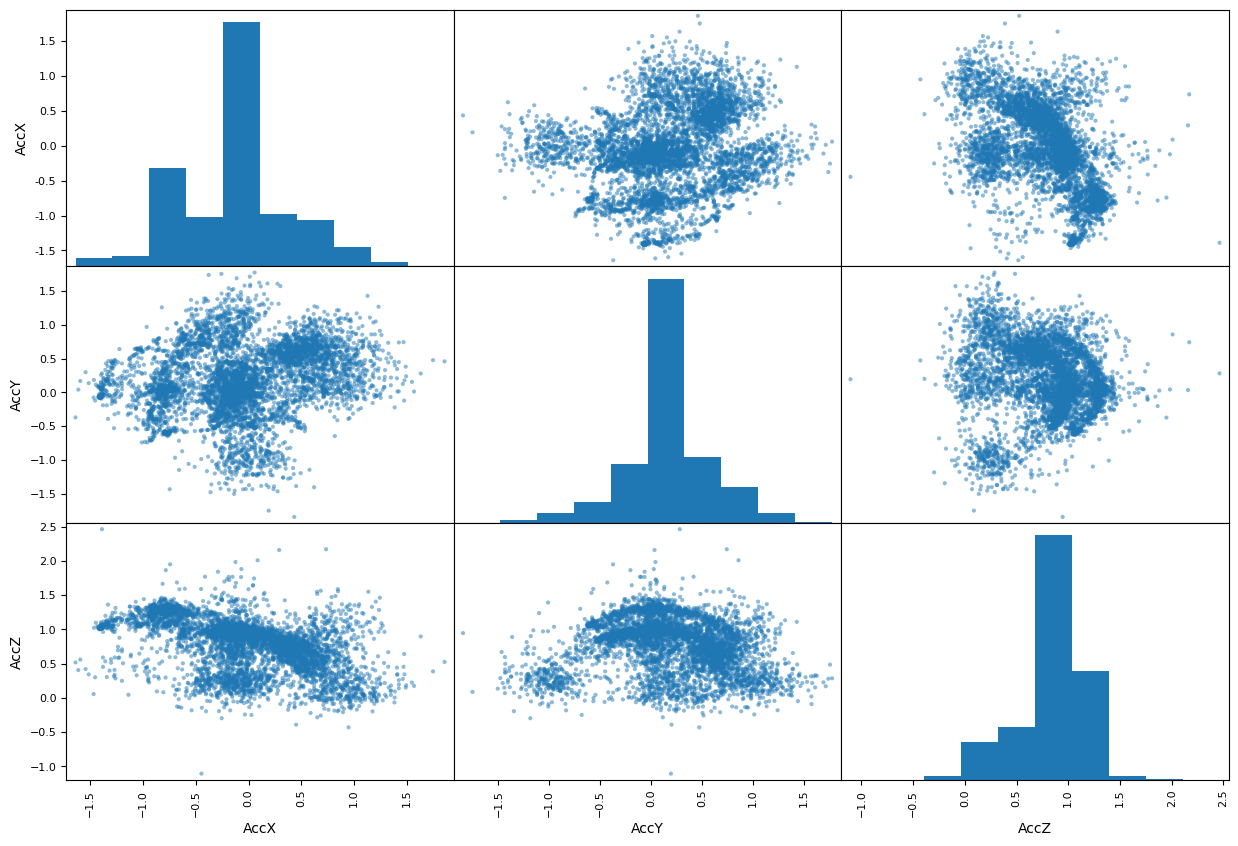

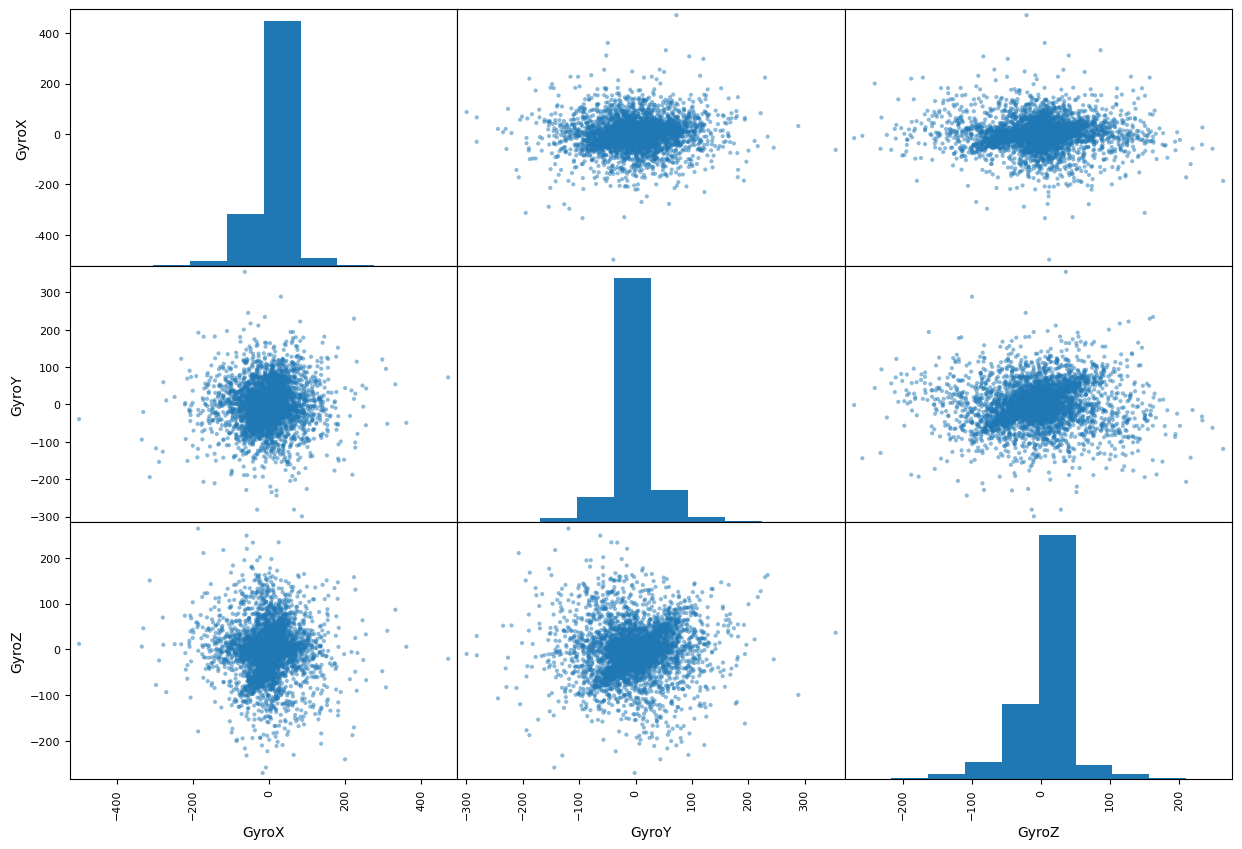

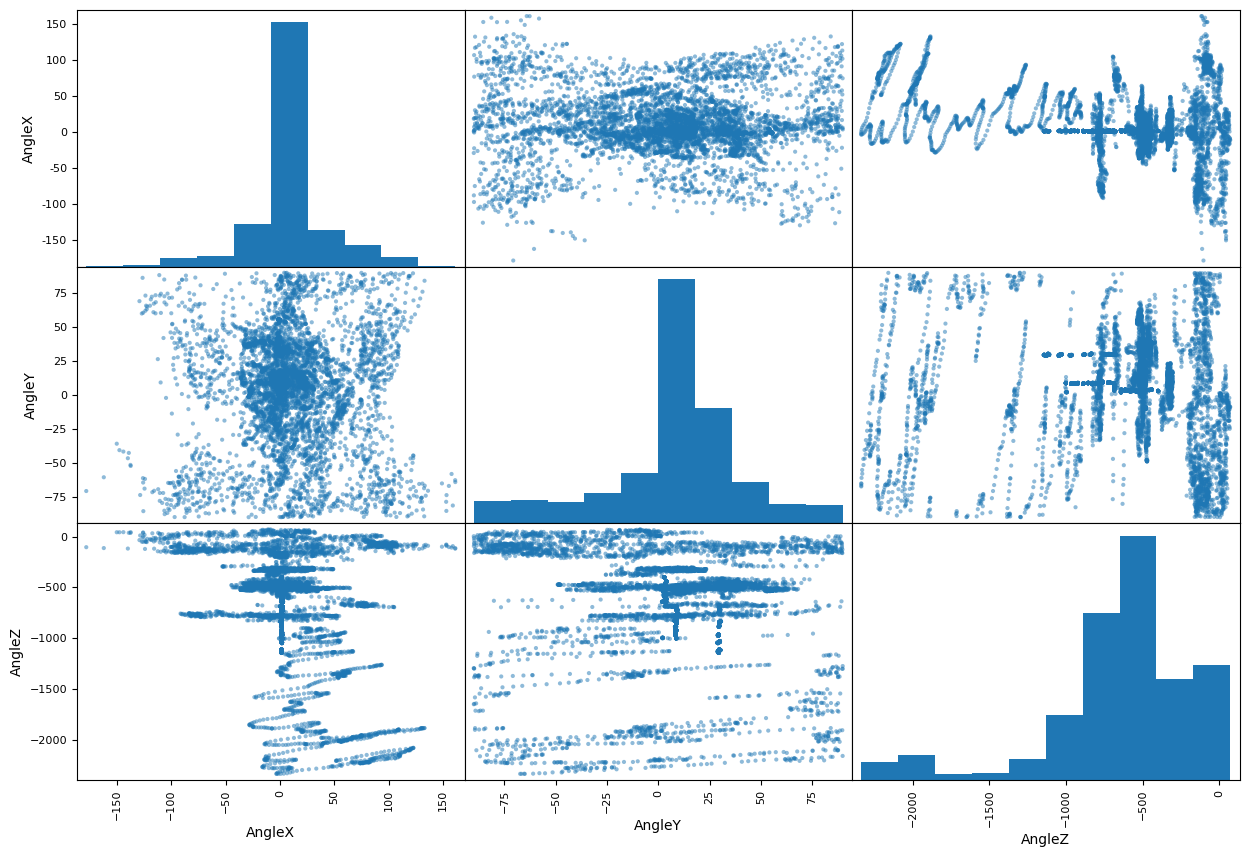

In [43]:
sensors = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'RuheState', 'FernstState', 'TranspState']

for sensor_group in [sensors[:3], sensors[3:6], sensors[6:9]]:
    scatmat(data[sensor_group], figsize=(15, 10))
    plt.show()

## 10. Scatterplots der unskalierten Daten für verschiedene Sensorpaare

In diesem Abschnitt sind die als vielversprechend geltenden Sensorpaare und die Klassenzugehörigkeit der Datenpunkte visualisiert. Hier sollten sich Cluster erkennen lassen, die später zur Klassifizierung genutzt werden. Ziel ist es, die Sensorpaare auszuwählen, bei welchen sich Cluster formen, bei denen die Datenpunkte immer nur zu einer Klasse gehören.

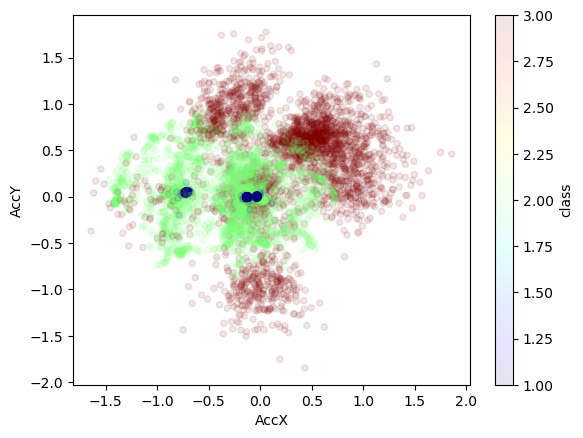

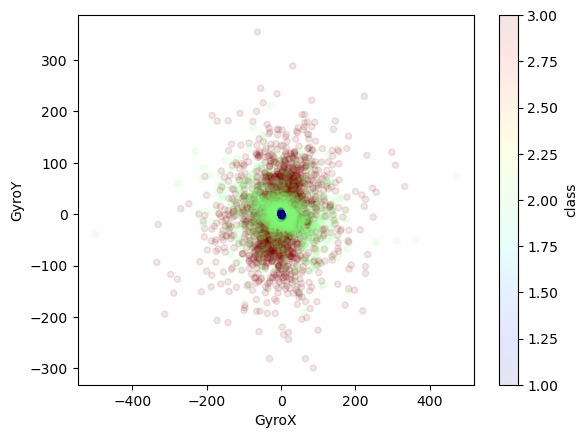

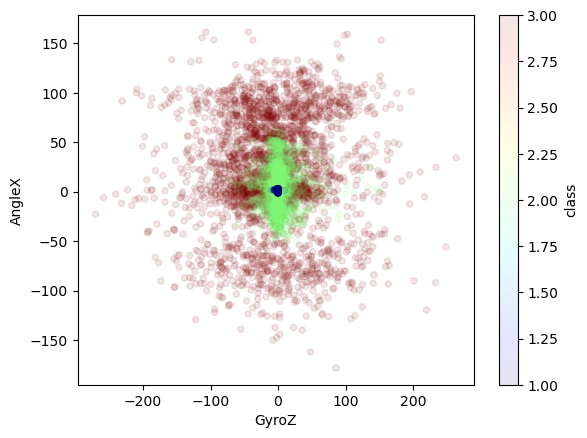

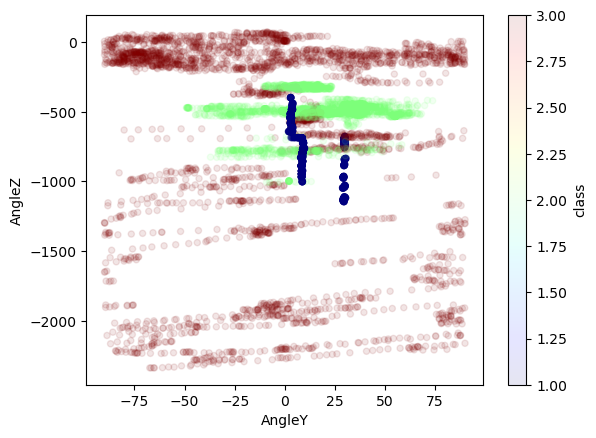

In [44]:
# Erstelle eine temporäre Spalte 'class' basierend auf One-Hot-Encoding
data['class'] = data.apply(lambda row: 1 if row['RuheState'] == 1 else (2 if row['FernstState'] == 1 else 3), axis=1)

# Visualisiere Scatterplots für jedes Sensor-Paar
sensor_pairs = [('AccX', 'AccY'), ('GyroX', 'GyroY'), ('GyroZ', 'AngleX'), ('AngleY', 'AngleZ')]
for pair in sensor_pairs:
    data.plot(kind="scatter", x=pair[0], y=pair[1], alpha=0.1, c='class', cmap=plt.get_cmap('jet'))
    #plt.title(f'Unskalierte Werte - {pair[0]} vs. {pair[1]}')
    plt.show()

# Entferne die temporäre 'class'-Spalte
data.drop('class', axis=1, inplace=True)


## 11. One Hot encoding der Klasse durchführen (Beispielhafte Anleitung)

Falls die Rohdaten noch nicht One-Hot-Encodiert sind, ist dies an dieser Stelle nachzuholen. Der verwendete Datensatz verwendet jedoch bereits One-Hot-Encoding.

In [45]:
#from sklearn.preprocessing import OneHotEncoder
#encoder = OneHotEncoder(categories='auto');

#data_label_matrix = data["class"].values.reshape(-1, 1)
#data_labels_1hot = encoder.fit_transform(data_label_matrix)
#data_labels_1hot.shape

## 12. Skatterplots von Messwertpaaren mit vorheriger Skalierung

In dieser Übersicht wird die Auswirkung der Skalierung auf die Messwerte visualisiert.

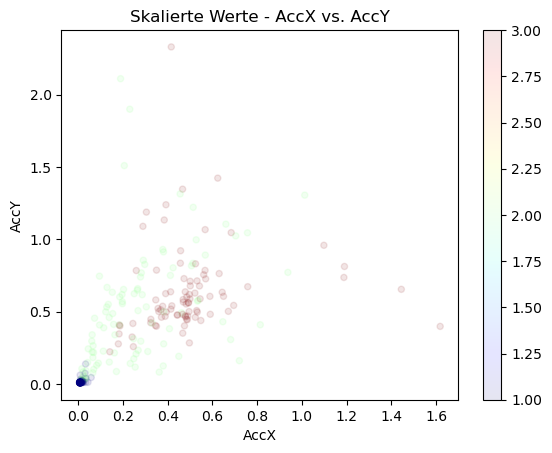

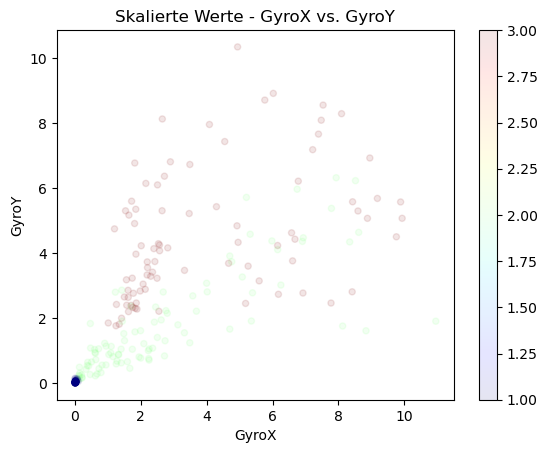

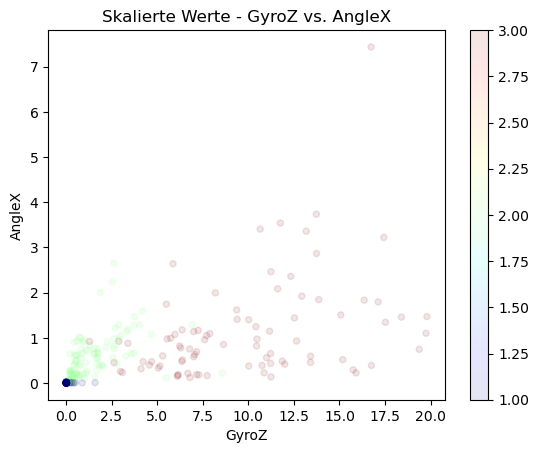

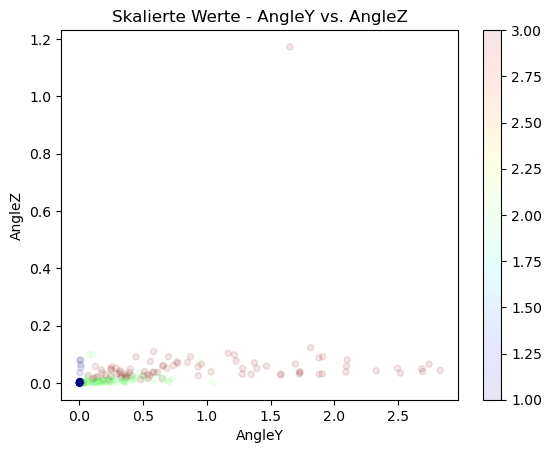

In [46]:
# Skalierte Werte in einem neuen DataFrame mit den ursprünglichen Spaltennamen
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)


# Erstelle eine temporäre Spalte 'class' basierend auf One-Hot-Encoding
data_scaled_df['class'] = data_scaled_df.apply(lambda row: 1 if row['RuheState'] == 1 else (2 if row['FernstState'] == 1 else 3), axis=1)


# Visualisiere Scatterplots für jedes Sensor-Paar mit den skalierten Werten und den originalen Klassen
sensor_pairs = [('AccX', 'AccY'), ('GyroX', 'GyroY'), ('GyroZ', 'AngleX'), ('AngleY', 'AngleZ')]
for pair in sensor_pairs:
    data_scaled_df.plot(kind="scatter", x=pair[0], y=pair[1], alpha=0.1, c=data_scaled_df['class'], cmap=plt.get_cmap('jet'))
    plt.title(f'Skalierte Werte - {pair[0]} vs. {pair[1]}')
    plt.show()

# Entferne die temporäre 'class'-Spalte
#data_scaled_df.drop('class', axis=1, inplace=True)


## 13. Ausgabe aller möglichen Sensorpaar Kombinationen

36


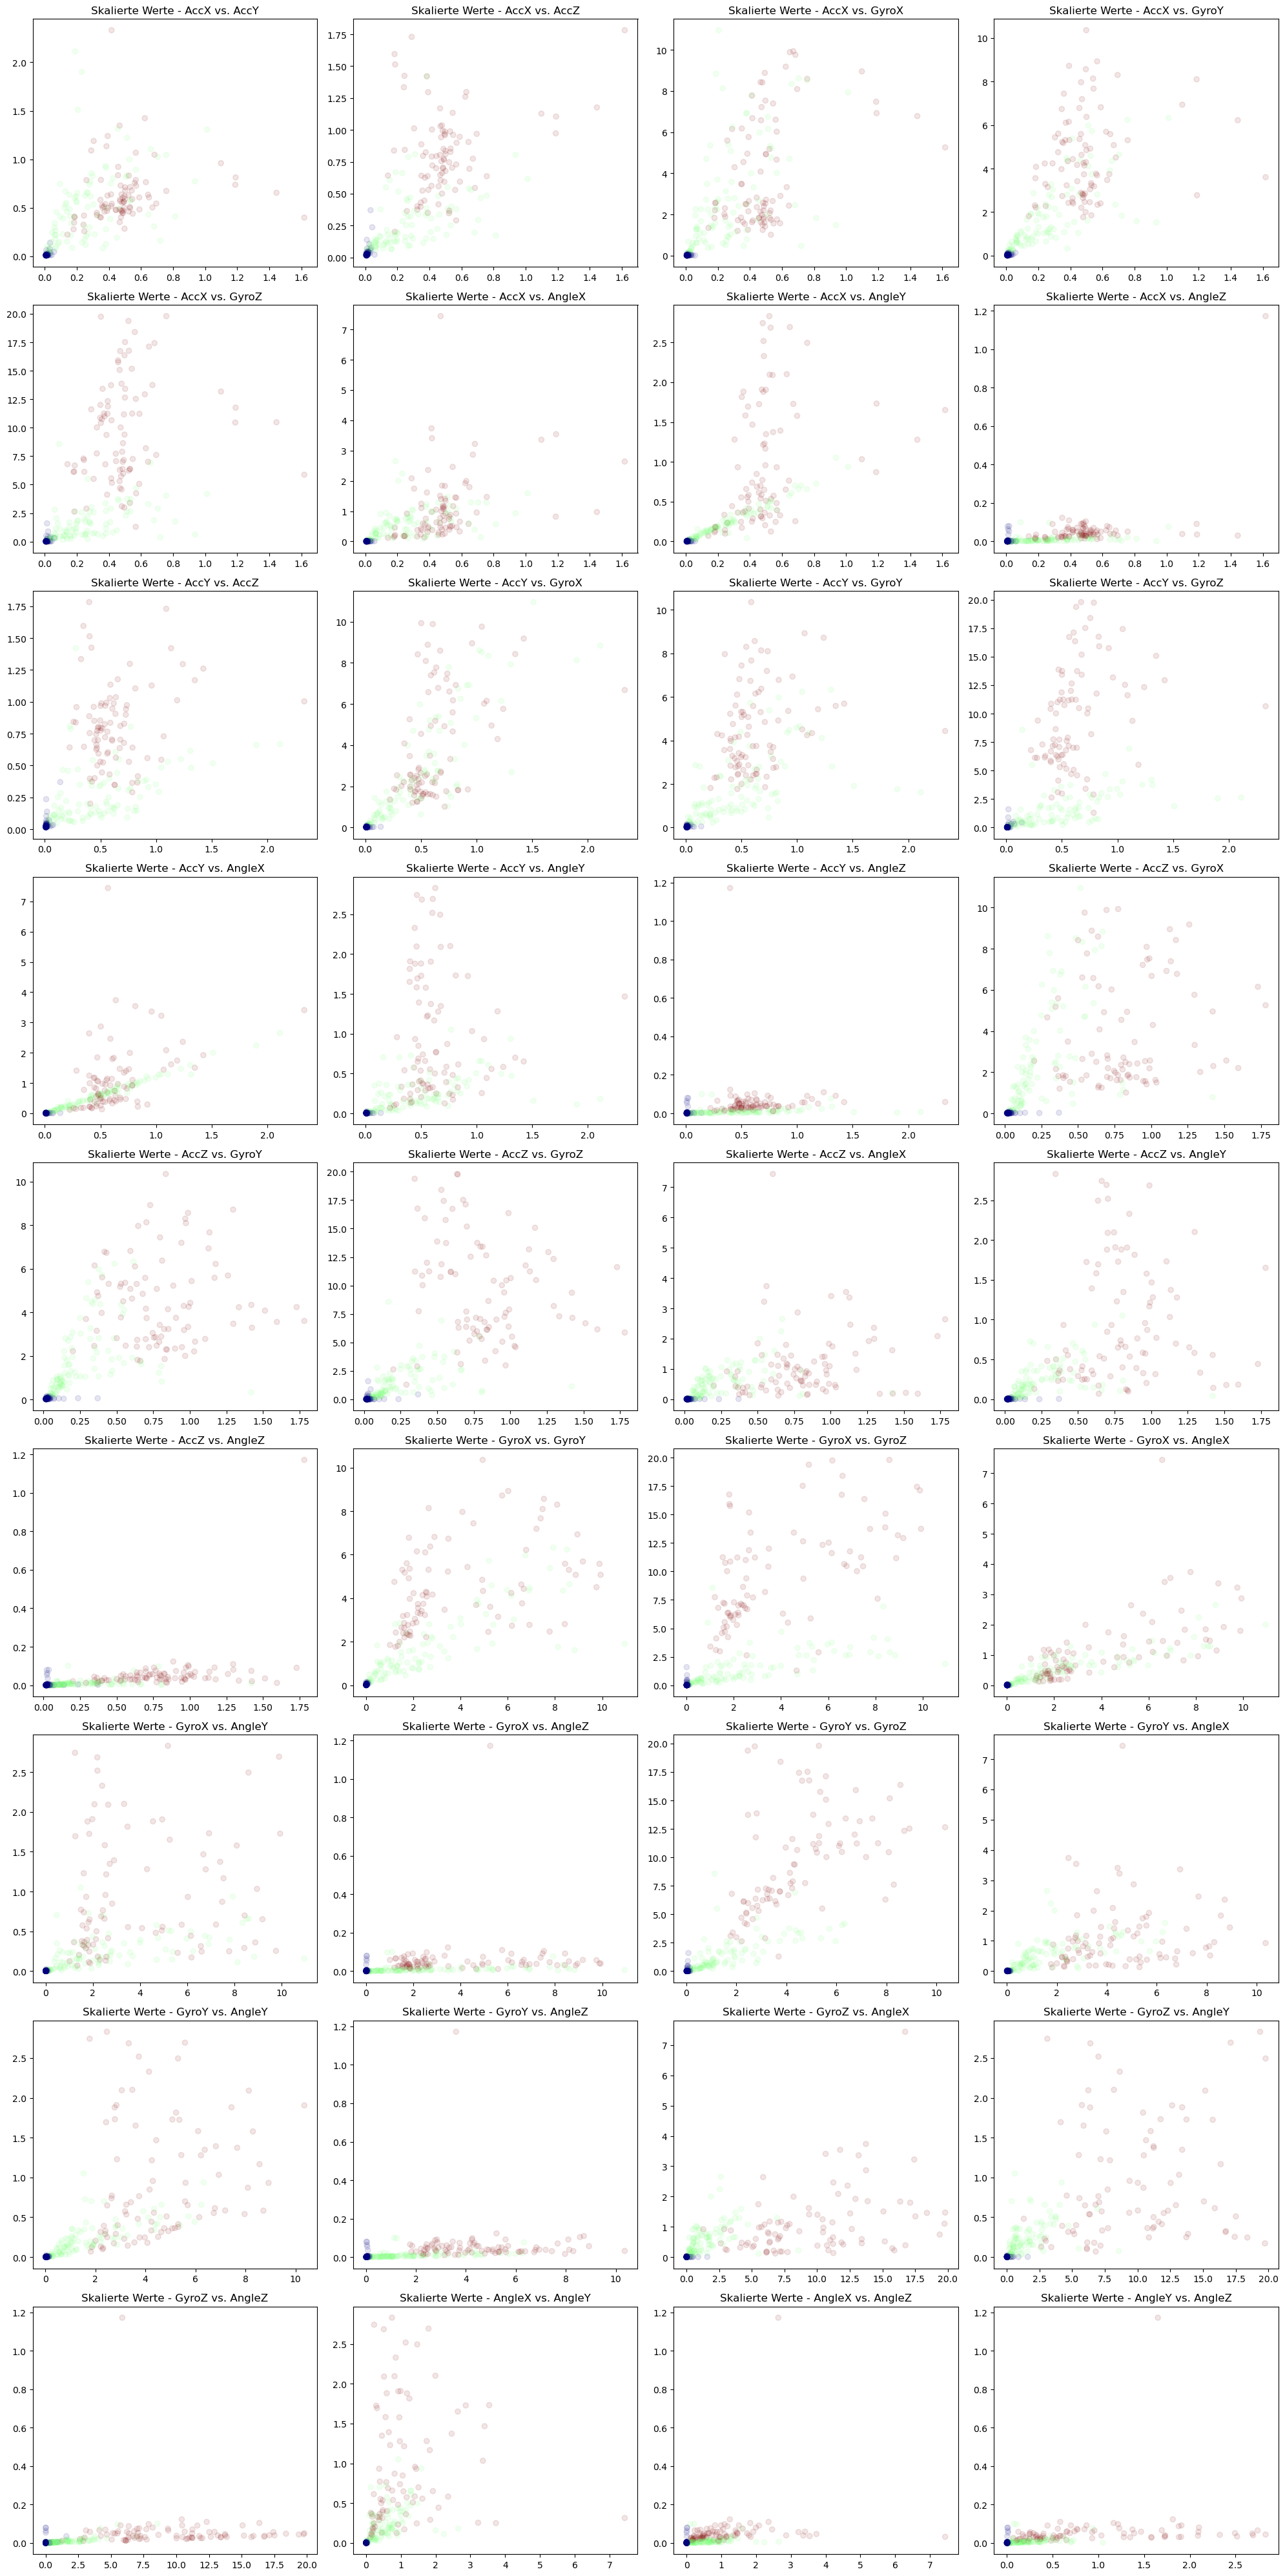

In [47]:
from itertools import combinations

# Skalierte Werte in einem neuen DataFrame mit den ursprünglichen Spaltennamen
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Erstelle eine temporäre Spalte 'class' basierend auf One-Hot-Encoding
data_scaled_df['class'] = data_scaled_df.apply(lambda row: 1 if row['RuheState'] == 1 else (2 if row['FernstState'] == 1 else 3), axis=1)

# Liste aller Labels
all_labels = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'RuheState', 'FernstState', 'TranspState']

# Erstelle alle möglichen Kombinationen von Label-Paaren
label_pairs = list(combinations(all_labels[0:9], 2))
print(len(label_pairs))

# Anzahl der Zeilen und Spalten für die Subplots
num_rows = 9  # Anzahl der gewünschten Zeilen
num_cols = 4  # Anzahl der gewünschten Spalten

# Erstelle Subplots
#plt.figure(figsize=(10, 8))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 40))

# Iteriere durch Label-Paare und erstelle Scatterplots
for i in range(num_rows):
    for j in range(num_cols):
        label_pair = label_pairs[i * num_cols + j]
        axs[i, j].scatter(data_scaled_df[label_pair[0]], data_scaled_df[label_pair[1]], alpha=0.1, c=data_scaled_df['class'], cmap=plt.get_cmap('jet'))
        axs[i, j].set_title(f'Skalierte Werte - {label_pair[0]} vs. {label_pair[1]}')

# Verbessere das Layout
plt.tight_layout()
plt.show()


## 14. Training des k-NN-Klassifikators

Das Training des k-NN-Klassifikators wird mit dem zuvor skalierten Trainingsdatensatz durchgeführt. 

**Hyperparameter tuning:**

Es konnte beobachtet werden, dass die Wahl von k=5, zur höchsten Accuracy in Schritt 17 führte.

In [48]:
from sklearn import neighbors
import numpy as np

num_features = 14
X = np.zeros([len(data_scaled_df), num_features])
y = data_scaled_df['class']

k = 5
clf = neighbors.KNeighborsClassifier(n_neighbors=k)
features = data_scaled_df.drop(columns='RuheState').drop(columns='class').drop(columns='TranspState').drop(columns='FernstState')
clf.fit(features, y)

KNeighborsClassifier()

## 15. Prediction und Accuracy

Nun wird die Prediction auf den Trainingsdatensatz und den Validierungsdatensatz durchgeführt und die dazugehörigen Accuracys bestimmt und ausgegeben.

In [49]:
# Prediction mit Trainingsdatensatz
y_predict = clf.predict(features)

# Berechnung der Accuracy
acc = np.mean(y_predict == (data_scaled_df['class']).astype(int).values)
acc

0.9743589743589743

Auf den Trainingsdaten kann eine Accuracy von 97,43 % erreicht werden.

In [50]:
# Prediction mit Validation-Array

# Vorverarbeittung wie beim Trainingsdatensatz
# Skalierte Werte in einem neuen DataFrame mit den ursprünglichen Spaltennamen
val_df = pd.DataFrame(val, columns=data.columns)

# Erstelle eine temporäre Spalte 'class' basierend auf One-Hot-Encoding
val_df['class'] = val_df.apply(lambda row: 1 if row['RuheState'] == 1 else (2 if row['FernstState'] == 1 else 3), axis=1)

val_labels = val_df['class']
val_data = val_df.drop(columns='RuheState').drop(columns='class').drop(columns='TranspState').drop(columns='FernstState')

# Prediction
prediction = clf.predict(val_data)

# Berechnung der Accuracy
acc = np.mean(prediction == val_labels.astype(int).values)
acc

1.0

Auf den Validierungsdaten kann eine Accuracy von 100% erreicht werden. Der Grund für eine soclh hohe Accuracy liegt in der geringen Anzahl an Datenpunkten, die für die Validierung und für das Training zur Verfügung standen. Es ist zu erwarten, dass dieses Ergebnis nicht bei Echtzeitdaten oder andere Testdatensätze reproduzierbar ist.

## 16. Python MQTT Client

Hier wird eine Datenstrucktur angelegt, die der Strucktur des Trainingsdatensatzes und Validierungsdatensazes entspricht. In diese werden die Daten geschrieben, die bei der Echtzeitverarbeitung vom MQTT-Broker geliefert werden.

In [51]:
live_data = {'AccX' :[],
        'AccY' : [],
        'AccZ' : [],
        'GyroX' : [],
        'GyroY' : [],
        'GyroZ' : [],
        'AngleX' : [],
        'AngleY' : [],
        'AngleZ' : [],
        'AccAngleX' : [],
        'AccAngleY' : [],     
        'RuheState' : 0,
        'FernstState' : 0,
        'TranspState' : 0,}

live_data_df = pd.DataFrame(live_data)

# Ausgabe der Datenstruktur
live_data_df.describe()

AccX  AccY  AccZ  GyroX  GyroY  GyroZ  AngleX  AngleY  AngleZ  \
count   0.0   0.0   0.0    0.0    0.0    0.0     0.0     0.0     0.0   
mean    NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
std     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
min     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
25%     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
50%     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
75%     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   
max     NaN   NaN   NaN    NaN    NaN    NaN     NaN     NaN     NaN   

       AccAngleX  AccAngleY  RuheState  FernstState  TranspState  
count        0.0        0.0        0.0          0.0          0.0  
mean         NaN        NaN        NaN          NaN          NaN  
std          NaN        NaN        NaN          NaN          NaN  
min          NaN        NaN        NaN          NaN          NaN  
25%          NaN        NaN        NaN          NaN          NaN  
50%          NaN        NaN        NaN          NaN          NaN  
75%          NaN        NaN        NaN          NaN          NaN  
max          NaN        NaN        NaN          NaN          NaN

## 17. MQTT Live-Prediction

In diesem Schritt wird die Live-Klassifizierung realisiert. 

In [52]:
import paho.mqtt.client as mqtt
from IPython.display import clear_output


live_data_df = pd.DataFrame(live_data)

# The callback for when the client receives a CONNACK response from the server.
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))

# The callback for when a PUBLISH message is received from the server.
counter = 0 # counts how many times angleZ is received 

def on_message(client, userdata, msg):
    global accX, accY, accZ, gyroX, gyroY, gyroZ, angleX, angleY, angleZ, accAngleX, accAngleY, live_data_df
    global counter
    if(msg.topic == 'accelerationX'):
        accX = msg.payload.decode('UTF-8')
        #print(accX)
    elif(msg.topic == 'accelerationY'):
        accY = msg.payload.decode('UTF-8')
        #print(accY)
    elif(msg.topic == 'accelerationZ'):
        accZ = msg.payload.decode('UTF-8')
    
    elif(msg.topic == 'gyrometerX'):
        gyroX = msg.payload.decode('UTF-8')
    elif(msg.topic == 'gyrometerY'):
        gyroY = msg.payload.decode('UTF-8')
    elif(msg.topic == 'gyrometerZ'):
        gyroZ = msg.payload.decode('UTF-8')

    elif(msg.topic == 'angleX'):
        angleX = msg.payload.decode('UTF-8')
    elif(msg.topic == 'angleY'):
        angleY = msg.payload.decode('UTF-8')
    elif(msg.topic == 'angleZ'):
        angleZ = msg.payload.decode('UTF-8')
    elif(msg.topic == 'accAngleX'):
        accAngleX = msg.payload.decode('UTF-8')
    elif(msg.topic == 'accAngleY'):
        accAngleY = msg.payload.decode('UTF-8')
        counter += 1

        new_row = {
        'AccX' :[accX],
        'AccY' : [accY],
        'AccZ' : [accZ],
        'GyroX' : [gyroX],
        'GyroY' : [gyroY],
        'GyroZ' : [gyroZ],
        'AngleX' : [angleX],
        'AngleY' : [angleY],
        'AngleZ' : [angleZ],
        'AccAngleX' : [accAngleX],
        'AccAngleY' : [accAngleY],
        'RuheState' : 0,
        'FernstState' : 0,
        'TranspState' : 0,
        }
        
        # convert new Data to DataFrame
        new_row = pd.DataFrame(new_row)

        # append new row to live_data_df
        live_data_df = pd.concat([new_row, live_data_df], ignore_index=True)

        # after 30 measurements, call the classifier
        if counter == 10:
            counter = 0
            live_data_scaled = pd.DataFrame(scaler.transform(live_data_df), columns=data.columns)   # scaling our data
            live_data_features = live_data_scaled.drop(columns='RuheState').drop(columns='TranspState').drop(columns='FernstState')
            # live_data_features = live_data_scaled[['AccY', 'GyroX']]

            std_df = live_data_features[selected_columns].std().to_frame().transpose()
            #print(std_df)

            #std_df = pd.DataFrame([['AccY', 'GyroX'], [std_accy, std_gyrox]])

            live_predict = clf.predict(std_df)
            print('Prediction: ', str(live_predict.mean()))
            if round(live_predict.mean()) == 1:
                print('Ruhe') 
            elif round(live_predict.mean()) == 2:
                print('Fernsteuerung') 
            elif round(live_predict.mean()) == 3:
                print('Transport')


            # Plotting 
            plt.figure(figsize=(10, 7))
            plt.scatter(train['AccY'], train['GyroX'],marker=".", alpha=0.3, c=data_scaled_df['class'], cmap=plt.get_cmap('rainbow'))
            plt.scatter(std_df['AccY'], std_df['GyroX'], marker="P", alpha=0.9, c=4, cmap=plt.get_cmap('jet'))
            #print(live_data_features)
            # axes = plt.gca()
            # axes.set_xlim([-5, 5])
            # axes.set_ylim([-20, 20])

            # Verbessere das Layout
            plt.tight_layout()
            plt.show()

            clear_output(wait=True)

            # Reset live_predict and live_data_df
            live_predict = None
            live_data_df = live_data_df.head(20) # keep 20 rows of the currenct frame

    
client = mqtt.Client()
client.on_connect = on_connect
client.on_message = on_message

client.connect("192.168.137.1", 1883, 60)
client.subscribe("ESP_message", 0)
client.subscribe("accelerationX", 0)
client.subscribe("accelerationY", 0)
client.subscribe("accelerationZ", 0)
client.subscribe("gyrometerX", 0)
client.subscribe("gyrometerY", 0)
client.subscribe("gyrometerZ", 0)
client.subscribe("angleX", 0)
client.subscribe("angleY", 0)
client.subscribe("angleZ", 0)
client.subscribe("accAngleX", 0)
client.subscribe("accAngleY", 0)


# Blocking call that processes network traffic, dispatches callbacks and
# handles reconnecting.
# Other loop*() functions are available that give a threaded interface and a
# manual interface.
client.loop_forever()

TimeoutError: timed out

## 18. Analyse der Qualität der Klassifizierung anhand von Confusions Matritzen

In diesem Abschnitt ist die Qualität der Klassifizierung anhand von Confusions Matritzen visualisiert. Bei 100% Accuracy wären nur die Felder auf der Hauptdiagonale besetzt.

In [53]:
import seaborn as sns
import pandas as pd

# Funktion zur Erstellung einer Confusion Matrix
def confusion_matrix(results, labels):
    data = {'y_Actual': results.astype(np.uint8), 'y_Predicted': labels}
    df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'])
    cm = cm.astype(np.float32) / cm.sum(axis=1).values[:, np.newaxis] * 100.0
    sns.heatmap(cm, annot=True, fmt='.1f', annot_kws={"size": 8})
    plt.title('Normalized Confusion Matrix in %')
    plt.show()

Ausgabe der Confusion Matritzen, der Validierungs- und Trainingsdaten.

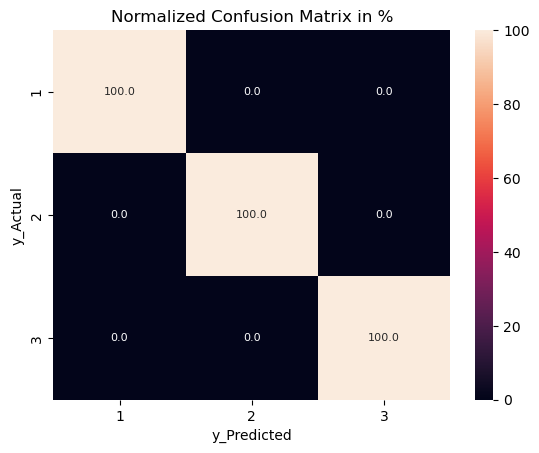

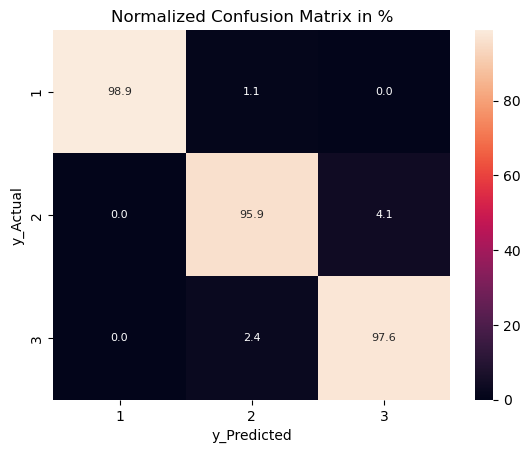

In [54]:
# Confusion Matritzen mit verarbeiteten Daten

# Ergebnis Validierungsdaten
confusion_matrix(prediction, val_labels.astype(int).values)

# Ergebnis Trainingsdaten
confusion_matrix(y_predict, (data_scaled_df['class']).astype(int).values)

Die erste Confusion Matrix visualisiert die Ergebnisse der Accuracy auf dem Validierungsdatensatz. Das numerische Ergebnis von 100% Accuracy deckt sich mit der beobachtung, dass nur Felder der Hauptdiagonalen besetzt sind und diese gleichzeitig 100% Accuracy enthalten.

Die zweite Confusion Matrix visualisiert die Ergebnisse der Accuracy auf dem Trainingsdatensatz. Es fällt auf, das die Klasse Ruhe am besten mit 98,9% korrekt klassifiziert wird. Dies ist plausibel, da sich die Sensordaten hier deutlich von denen der anderen zwei Klassen unterscheiden, indem sie nur eine kleine Standardabweichung aufweisen. Die anderen beiden Klassen werden mit jeweils 95,9% (Klasse 2) und 97,6% korrekt klassifiziert. Zusammen ergeben die Klassenspezifischen Accuracys die erwartete durchschnittliche Accuracy von knapp über 97%.

## 19. Fazit

In diesem Inkrement konnten wir das Vorgehen, bei der korrekten Vorverarbeitung von Daten, dem Trainieren eines k-NN-Klassifikators und der Bewertung der Klassifizierungsergebnisse vertiefen. Darüber hinaus wurde deutlich wie einfach Feature-Engineering anhand der Visualisierung von Sensorpaaren durchgeführt werden kann. Desweiteren wurde deutlich das die Weiterverarbeitung von Sensorrohdaten zu einer erheblichen Verbesserung des Klassifizierungsergebnisses führt. Allein mit der Standardabweichung, als einzige Kenngröße konnte eine Accuracy von mindestens 97% erziehlt werden. Das ergänzen von weiteren statistischen Werten, wie dem Minimum, Maximum oder Zeitabhängigen Größen, wie beispielsweise der Geschwindigkeit würden dieses Ergebnis vermutlich noch verbessern.

## 20. Anhang

### Verwendetes Node-Red-Netzwerk

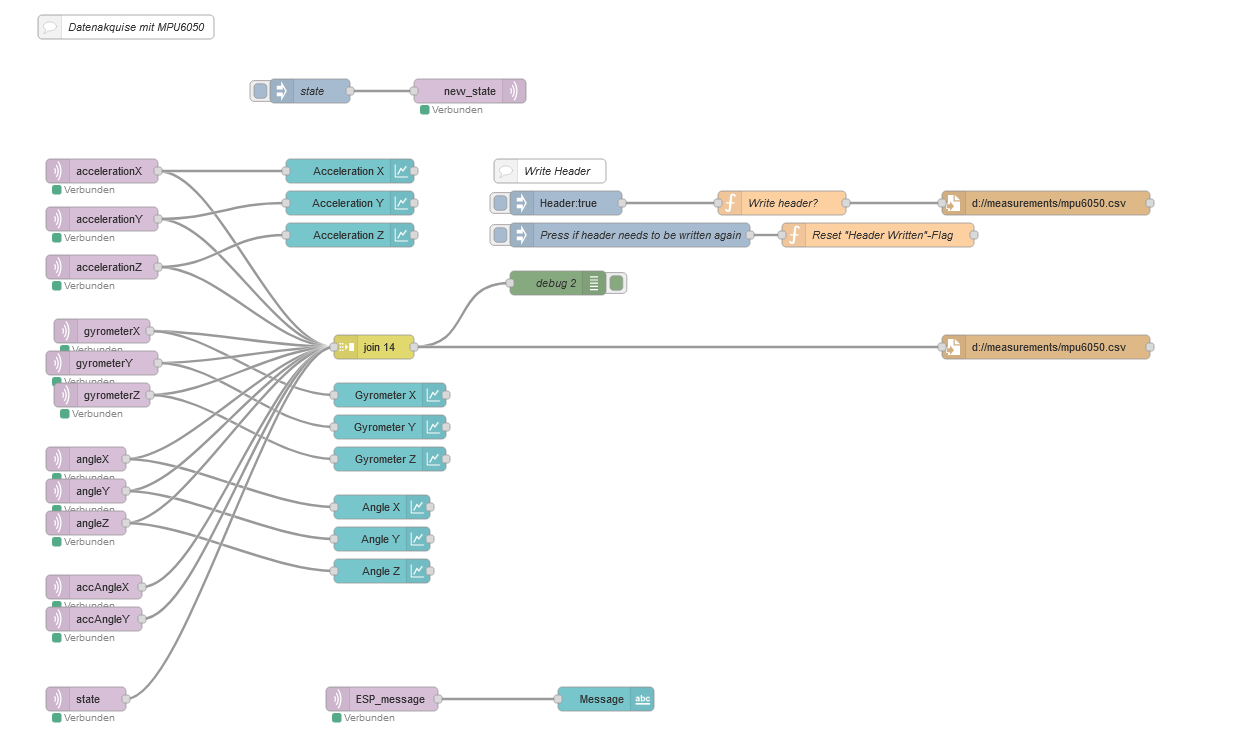

Die Darstellung illustriert das Node-Red-Netzwerk, das für die Erfassung des Datensatzes verwendet wird. Durch Aktivierung des blau hervorgehobenen Insert-Bausteins (Header) kann der Kopfzeilen-Header des CSV-Files manuell eingefügt werden. Der Zustand (State) kann mithilfe des Insert-Bausteins (state) modifiziert werden. Hierfür ist vor der Aktivierung des Bausteins der Zustand als Zahlenwert 1..3 im Payload einzutragen, wobei 1 für Ruhe, 2 für Fernsteuerung und 3 für Transport steht. Der Baustein "state" ist ausschließlich für die Datenerfassung zu verwenden und besitzt bei einer Live-Klassifizierung keine Funktion.